In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import datetime
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from keras.layers import Bidirectional, GlobalMaxPool1D
from tqdm import tqdm_notebook
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1308984798696364150
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10057666703699374684
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
!pip install bayesian-optimization

### data 불러오기

In [5]:
Y_초순 = pd.read_csv('Y_초순.csv')
Y_중순 = pd.read_csv('Y_중순.csv')
Y_하순 = pd.read_csv('Y_하순.csv')

In [6]:
Y_초순

,UID,패션초순구입,가전제품초순구입,화장품초순구입
0,20120712210FAAE99B43,1,1,0
1,201207175F12579F84D4,0,0,1
2,20120723EC3C68DA5E56,0,1,0
3,201207252C25DC618A00,0,1,1
4,2012072582E08BEB79C6,0,0,1
...,...,...,...,...
1058,201407051A8A544E7F79,0,0,1
1059,20140705A1F86A14CC89,0,1,0
1060,20140706952D03CA2CF1,0,0,0
1061,2014070991B7C8F3BBD9,0,0,0


In [7]:
X_초순 = pd.read_csv('초순_3d_array.csv')
X_중순 = pd.read_csv('중순_3d_array.csv')
X_하순 = pd.read_csv('하순_3d_array.csv')

In [8]:
X_초순.head()

,0,1,2,3,4,5,6,7,8,9,...,94990,94991,94992,94993,94994,94995,94996,94997,94998,94999
0,1754,29010,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,308,10185,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,24,314,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1302,29956,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1361,7985,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [9]:
X_초순 = np.asarray(X_초순)
X_중순 = np.asarray(X_중순)
X_하순 = np.asarray(X_하순)

In [10]:
Y_초순 = np.asarray(Y_초순.iloc[:, 1:])
Y_중순 = np.asarray(Y_중순.iloc[:, 1:])
Y_하순 = np.asarray(Y_하순.iloc[:, 1:])

In [11]:
X_초순 = X_초순.reshape(1063, 5000, 19)
X_중순 = X_중순.reshape(1063, 5000, 19)
X_하순 = X_하순.reshape(1063, 5000, 19)

### LSTM 가동

In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 초순

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
X_초순, Y_초순, test_size=0.3, random_state=42)

In [ ]:
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [112]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
def get_model(input_shape):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64,input_shape = input_shape))
    #model.add(GlobalMaxPool1D())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation= 'relu'))
    model.add(Dense(4, activation='sigmoid'))

    return model


In [ ]:
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
    print(model.summary())

#### Bayesian Optimization

In [131]:
def fit_with(input_shape, verbose, lr):

    # Create the model using a specified hyperparameters.
    model = get_model(input_shape)

    # Train the model for a specified number of epochs.
    optimizer = RMSprop(learning_rate=lr)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model with the train dataset.
    model.fit(x=X_train,y= y_train ,epochs=1,
              batch_size=64, verbose=verbose)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(X_test,y= y_test ,steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Return the accuracy.

    return score[1]
from functools import partial
input_shape = (X_train.shape[1], X_train.shape[2])
verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [132]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)


for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |    lr     |
-------------------------------------
Epoch 1/1
1606/1606 [==============================] - 116s 72ms/step - loss: 1.2703 - accuracy: 0.3767
Test loss: 0.10801259279251099
Test accuracy: 4.716981053352356
|  1        |  4.717    |  0.004229 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.0698 - accuracy: 0.4284
Test loss: 0.10224945545196533
Test accuracy: 4.296081364154816
|  2        |  4.296    |  0.007231 |
Epoch 1/1
1606/1606 [==============================] - 125s 78ms/step - loss: 1.4472 - accuracy: 0.2416
Test loss: 0.14132689237594603
Test accuracy: 3.294629752635956
|  3        |  3.295    |  0.000101 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.1305 - accuracy: 0.4732
Test loss: 0.09361357092857361
Test accuracy: 5.703918933868408
|  4        |  5.704    |  0.003093 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.1579 - accuracy: 0.3

### Main MOdel

In [14]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Glob)
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.003, rho = 0.9))
print(model.summary())

W0211 11:33:46.560149 139754087118656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 24,163
Trainable params: 24,163
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)

W0211 11:33:47.187179 139754087118656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 744 samples, validate on 319 samples
Epoch 1/30
 - 30s - loss: 0.8772 - val_loss: 0.8609
Epoch 2/30
 - 30s - loss: 0.8719 - val_loss: 0.8590
Epoch 3/30
 - 30s - loss: 0.8684 - val_loss: 0.8612
Epoch 4/30
 - 30s - loss: 0.8641 - val_loss: 0.8613
Epoch 5/30
 - 31s - loss: 0.8603 - val_loss: 0.8642
Epoch 6/30
 - 44s - loss: 0.8567 - val_loss: 0.8673
Epoch 7/30
 - 44s - loss: 0.8508 - val_loss: 0.8781
Epoch 8/30
 - 44s - loss: 0.8471 - val_loss: 0.8847
Epoch 9/30
 - 44s - loss: 0.8418 - val_loss: 0.8836
Epoch 10/30
 - 44s - loss: 0.8360 - val_loss: 0.8873
Epoch 11/30
 - 44s - loss: 0.8305 - val_loss: 0.8877
Epoch 12/30
 - 44s - loss: 0.8230 - val_loss: 0.9069
Epoch 13/30
 - 44s - loss: 0.8213 - val_loss: 0.8945
Epoch 14/30
 - 44s - loss: 0.8181 - val_loss: 0.8982
Epoch 15/30
 - 44s - loss: 0.8125 - val_loss: 0.9122
Epoch 16/30
 - 44s - loss: 0.8027 - val_loss: 0.9166
Epoch 17/30
 - 44s - loss: 0.8030 - val_loss: 0.9128
Epoch 18/30
 - 44s - loss: 0.7869 - val_loss: 0.9296
Epoch 19/

In [29]:
preds = model.predict(X_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [30]:
preds

array([[1.39892101e-04, 1.27440691e-02, 3.19618285e-02],
       [1.36760414e-01, 3.03606629e-01, 4.15020376e-01],
       [2.07568288e-01, 3.12772036e-01, 1.51957542e-01],
       [1.66997790e-01, 1.41199738e-01, 2.41556555e-01],
       [1.37333989e-01, 3.75136554e-01, 4.44858789e-01],
       [1.67945325e-02, 9.41620171e-02, 1.08144045e-01],
       [2.00342119e-01, 7.37184286e-02, 8.55875909e-02],
       [3.53851944e-01, 1.83645248e-01, 2.65966237e-01],
       [1.92403525e-01, 3.06883156e-01, 6.82542026e-02],
       [3.47204179e-01, 2.38875628e-01, 1.33252382e-01],
       [1.24166816e-01, 3.58075500e-01, 3.28802913e-01],
       [2.79790580e-01, 3.60766947e-01, 2.89808273e-01],
       [2.45070010e-01, 3.50970984e-01, 2.53310233e-01],
       [1.54566437e-01, 2.74843693e-01, 2.67844379e-01],
       [8.91028047e-02, 1.08427733e-01, 1.75493926e-01],
       [3.61856818e-03, 5.82008958e-02, 2.37311512e-01],
       [1.64956778e-01, 1.20637596e-01, 1.96472794e-01],
       [4.61695194e-02, 2.98529

#### feature importance

In [137]:
train_df = pd.DataFrame(X_train.reshape(1606*5000, 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']
## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

   varible_name  perturbation_effect
17      컴퓨터/인터넷             0.105500
6            기타             0.067070
9       비즈니스/쇼핑             0.064833
0    세션당 방문사이트수             0.037320
7        뉴스/미디어             0.025902
1        세션지속시간             0.016763
8         문화/예술             0.014035
3            게임             0.005174
11       스포츠/레저             0.005075
15        정치/사회             0.002527
10        생활/건강             0.002033
2     쇼핑사이트방문여부             0.001977
5         교육/학교             0.001861
4        경제/재테크             0.001658
13        연예/오락             0.000948
18        학문/사전             0.000616
14           인물             0.000532
12      여행/세계정보             0.000301
16           종교             0.000023


In [138]:
#perm = PermutationImportance(model, random_state=1).fit(X_test,y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [139]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [140]:
#가전제품 f1-score: 0.7819220343082984
#패션 accuracy: 0.7188029361269287

print(accuracy)

0.6023222208023071


#### 중순

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
X_중순, Y_중순, test_size=0.3, random_state=42)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [17]:
#쇼핑사이트 방문횟수, 문화/예술, 비즈니스/쇼핑

In [18]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Glob)
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 24,163
Trainable params: 24,163
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, y_train, epochs=30, batch_size=200, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 744 samples, validate on 319 samples
Epoch 1/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/30
 - 20s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/30
 - 20s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/30
 - 20s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/30
 - 20s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/30
 - 20s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 12/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/30
 - 21s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 14/30
 - 20s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/30
 - 31s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 16/30
 - 20s - loss: 0.0000e+00 - val_loss

In [20]:
preds = model.predict(X_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [36]:
preds

array([[0., 1., 1.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [0., 1., 0.],
       [1., 0., 1.],
       [1., 0., 0.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 0., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [0., 1., 0.],
       [1., 1., 0.],
       [0., 1., 1.],
       [1., 1., 0.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 0., 0.],
       [1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [1., 0., 0.],
       [1., 1., 0.],
       [0., 1., 0.],
       [1., 1., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.],
       [1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [1., 0

#### feature importance

In [148]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0] * X_train.shape[1], 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']

## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

   varible_name  perturbation_effect
6            기타             0.019017
0    세션당 방문사이트수             0.018900
9       비즈니스/쇼핑             0.017860
17      컴퓨터/인터넷             0.011322
1        세션지속시간             0.005882
3            게임             0.004853
2     쇼핑사이트방문여부             0.002543
7        뉴스/미디어             0.002450
15        정치/사회             0.002309
5         교육/학교             0.001170
4        경제/재테크             0.000860
16           종교             0.000262
11       스포츠/레저             0.000238
10        생활/건강             0.000212
12      여행/세계정보             0.000210
18        학문/사전             0.000137
13        연예/오락             0.000118
8         문화/예술             0.000115
14           인물             0.000049


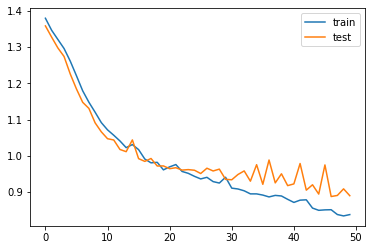

In [149]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()                       

In [150]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [151]:
print(accuracy)

0.632478654384613


#### 하순

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
X_하순, Y_하순, test_size=0.3, random_state=42)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [27]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9))
print(model.summary())

SyntaxError: invalid syntax (<ipython-input-27-f2d3bf183aa0>, line 8)

In [28]:
history = model.fit(X_train, y_train, epochs=60, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 744 samples, validate on 319 samples
Epoch 1/60
 - 28s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/60
 - 27s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/60
 - 27s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/60
 - 27s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/60
 - 26s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/60
 - 26s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/60
 - 27s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/60
 - 27s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/60


ResourceExhaustedError: OOM when allocating tensor with shape[5000,500,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node training_1/RMSprop/gradients/lstm_2/strided_slice_18_grad/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0] * X_train.shape[1], 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']
## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

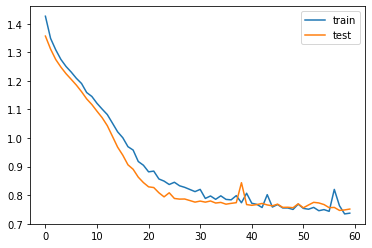

In [156]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()       